In [5]:
"""
Created on Sat Aug 19 05:09:59 2023

@author: Noam
"""
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import urllib
import datetime as dt
import json

from sklearn.preprocessing import MinMaxScaler

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
# General fit function for various models we will use
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


In [7]:
# DATA WINDOWING GENERATOR
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_window(self, features):
      inputs = features[:, self.input_slice, :]
      labels = features[:, self.labels_slice, :]
      if self.label_columns is not None:
          labels = tf.stack(
              [labels[:, :, self.column_indices[name]] for name in self.label_columns],
              axis=-1)

      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
      inputs.set_shape([None, self.input_width, None])
      labels.set_shape([None, self.label_width, None])

      return inputs, labels

  def plot(self, plot_col, max_subplots=3,model=None):
      inputs, labels = self.example
      plt.figure(figsize=(12, 8))
      plot_col_index = self.column_indices[plot_col]
      max_n = min(max_subplots, len(inputs))
      for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
          label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
          label_col_index = plot_col_index

        if label_col_index is None:
          continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
          predictions = model(inputs)
          plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
          plt.legend()

      plt.xlabel('Time [d]')

  def make_dataset(self, data):
      data = np.array(data, dtype=np.float32)
      ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

      ds = ds.map(self.split_window)

      return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])



In [8]:
# Baseline prediction model, returns last sample value as next 'prediction' (reasonable accuracy as stock prices change slowly)
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta




In [26]:
# Simple wrapper for Residual Models tracking the Delta and Previous Output
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

In [24]:
# INITIAL SETTINGS

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


api_key = 'M8UQX1OZQCMXC7R5'

# Selected Stock Ticker
stock_selected = "NVDA"

# url request string for selected ticker
# JSON file with stock market data for stock_selected
url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(stock_selected,api_key)

# Save data
file_to_save = 'stock_data-%s.csv'%stock_selected

# EPOCHS
MAX_EPOCHS = 20

# performance info
val_performance = {}
performance = {}
multi_val_performance = {}
multi_performance = {}



In [11]:
# SETUP

# If data is not already saved
if not os.path.exists(file_to_save):
    # load json from url request
    # store date, low, high, volume, close, open values to a Pandas DataFrame
    with urllib.request.urlopen(url_string) as url:
        data = json.loads(url.read().decode())
        # extract actual data from json
        data = data['Time Series (Daily)']
        df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
        for k,v in data.items():
            date = dt.datetime.strptime(k, '%Y-%m-%d')
            data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                        float(v['4. close']),float(v['1. open'])]
            df.loc[-1,:] = data_row
            df.index = df.index + 1
    print('Data saved to : %s'%file_to_save)
    df.to_csv(file_to_save)

# If data is saved, only load
else:
    print('File already exists. Loading data from CSV')
    df = pd.read_csv(file_to_save)

df = df.sort_values('Date')


# fix date strings to numeric features
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

df.drop(columns=['Date'], inplace=True)


Data saved to : stock_data-NVDA.csv


All shapes are: (batch, time, features)
Window shape: (3, 8, 7)
Inputs shape: (3, 7, 7)
Labels shape: (3, 1, 1)
Inputs shape (batch, time, features): (32, 7, 7)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)


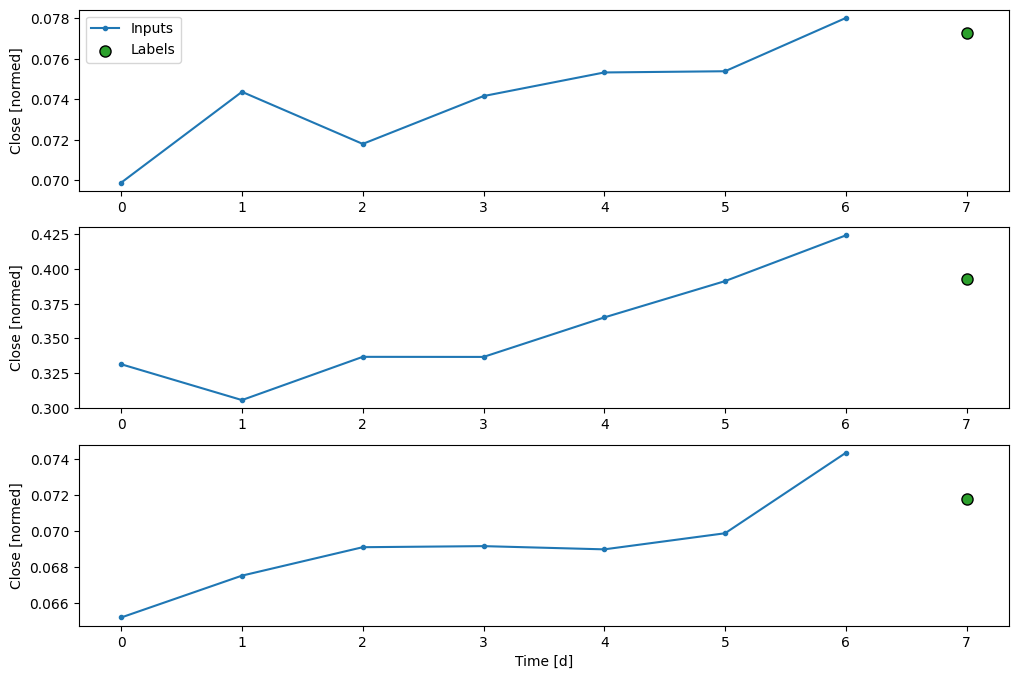

In [44]:
# DATA SETS SPLIT

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

# Calculate mean and standard deviation
train_mean = train_df.mean(numeric_only=True)
train_std = train_df.std(numeric_only=True)

# normalize data sets around [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))  # Scale features between 0 and 1
# based on training data set ONLY
scaler.fit(train_df)
train_df = scaler.transform(train_df)
val_df = scaler.transform(val_df)
test_df = scaler.transform(test_df)

# convert the NumPy arrays back to DataFrames
train_df = pd.DataFrame(train_df, columns=df.columns)
val_df = pd.DataFrame(val_df, columns=df.columns)
test_df = pd.DataFrame(test_df, columns=df.columns)

# generate data window, 24 samples (days) with 24 (days) offset, target label is closing price
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, train_df = train_df, val_df = val_df, test_df = test_df,
                     label_columns=['Close'])

# generate data window, 7 samples (days) with 1 (days) offset, target label is closing price
w2 = WindowGenerator(input_width=7, label_width=1, shift=1, train_df = train_df, val_df = val_df, test_df = test_df,
                     label_columns=['Close'])

example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)


print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

w2.plot(plot_col='Close')

for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


single_step_window = WindowGenerator(train_df = train_df, val_df = val_df, test_df = test_df,
    input_width=1, label_width=1, shift=1,
    label_columns=['Close'])

for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


38/38 [==============================] - 0s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0323
Input shape: (32, 30, 7)
Output shape: (32, 30, 1)


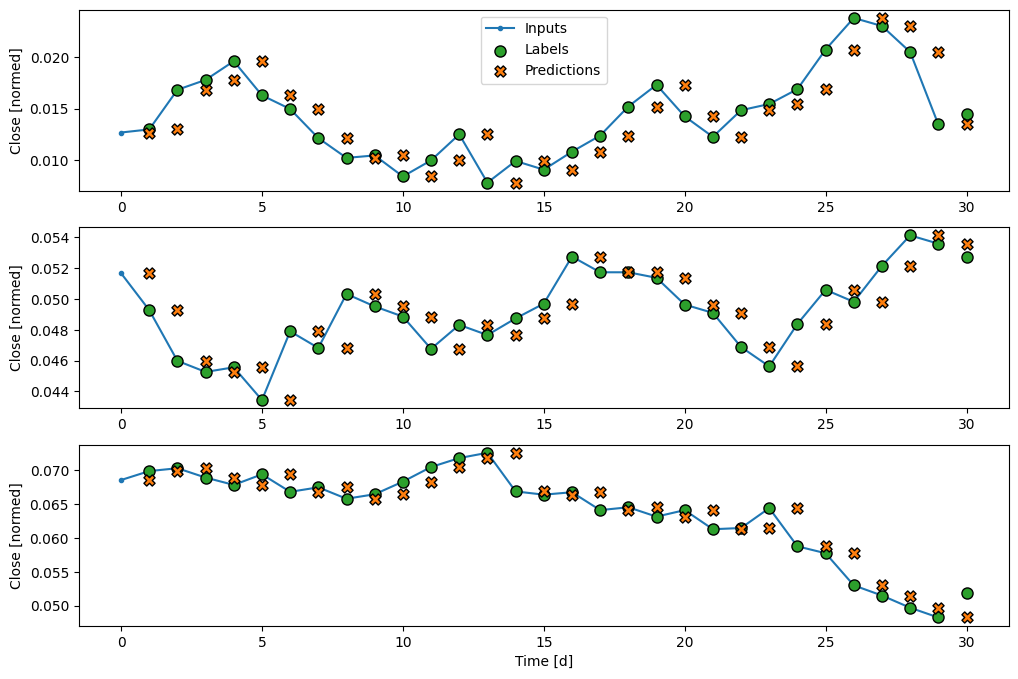

In [45]:
# generate baseline model for single step window, LOSS = MSE
baseline = Baseline(label_index=column_indices['Close'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

# this wide window predicts one step (day) at a time, but checks a month of predictions (input is 30 days, target labels are 30 days)

wide_window = WindowGenerator(train_df = train_df, val_df = val_df, test_df = test_df,
    input_width=30, label_width=30, shift=1,
    label_columns=['Close'])


print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

wide_window.plot(model=baseline,plot_col = 'Close')

Epoch 1/20
133/133 [==============================] - 1s 6ms/step - loss: 0.1284 - mean_absolute_error: 0.2847 - val_loss: 0.1423 - val_mean_absolute_error: 0.2860
Epoch 2/20
133/133 [==============================] - 1s 5ms/step - loss: 0.0701 - mean_absolute_error: 0.2150 - val_loss: 0.0611 - val_mean_absolute_error: 0.2007
Epoch 3/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0462 - mean_absolute_error: 0.1751 - val_loss: 0.1060 - val_mean_absolute_error: 0.2807
Epoch 4/20
38/38 [==============================] - 0s 4ms/step - loss: 0.1489 - mean_absolute_error: 0.3391


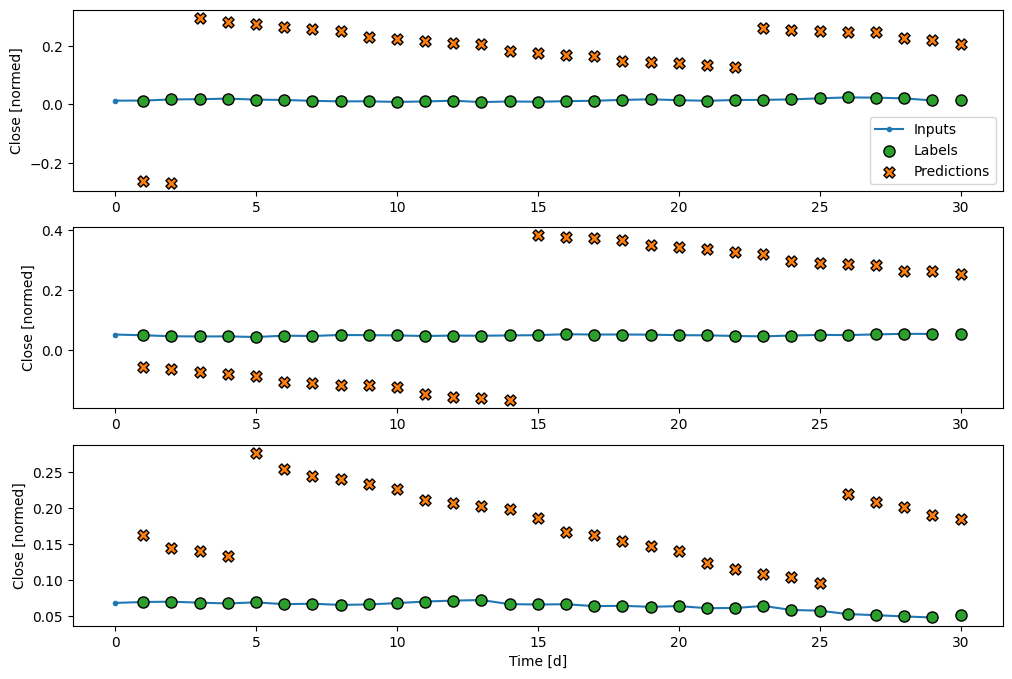

In [46]:
# Linear model on single step window
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

# plot on wide window (the fitting from the single step window works for this window as well, as they evaulate the same way)
wide_window.plot('Close',model=linear)

Epoch 1/20
133/133 [==============================] - 3s 15ms/step - loss: 0.0019 - mean_absolute_error: 0.0228 - val_loss: 0.0059 - val_mean_absolute_error: 0.0541
Epoch 2/20
133/133 [==============================] - 1s 5ms/step - loss: 2.7582e-04 - mean_absolute_error: 0.0082 - val_loss: 0.0081 - val_mean_absolute_error: 0.0664
Epoch 3/20
133/133 [==============================] - 1s 6ms/step - loss: 2.9859e-04 - mean_absolute_error: 0.0087 - val_loss: 0.0046 - val_mean_absolute_error: 0.0479
Epoch 4/20
133/133 [==============================] - 1s 5ms/step - loss: 2.7769e-04 - mean_absolute_error: 0.0083 - val_loss: 0.0045 - val_mean_absolute_error: 0.0483
Epoch 5/20
133/133 [==============================] - 1s 6ms/step - loss: 2.7341e-04 - mean_absolute_error: 0.0080 - val_loss: 0.0069 - val_mean_absolute_error: 0.0634
Epoch 6/20
38/38 [==============================] - 0s 3ms/step - loss: 0.0062 - mean_absolute_error: 0.0592


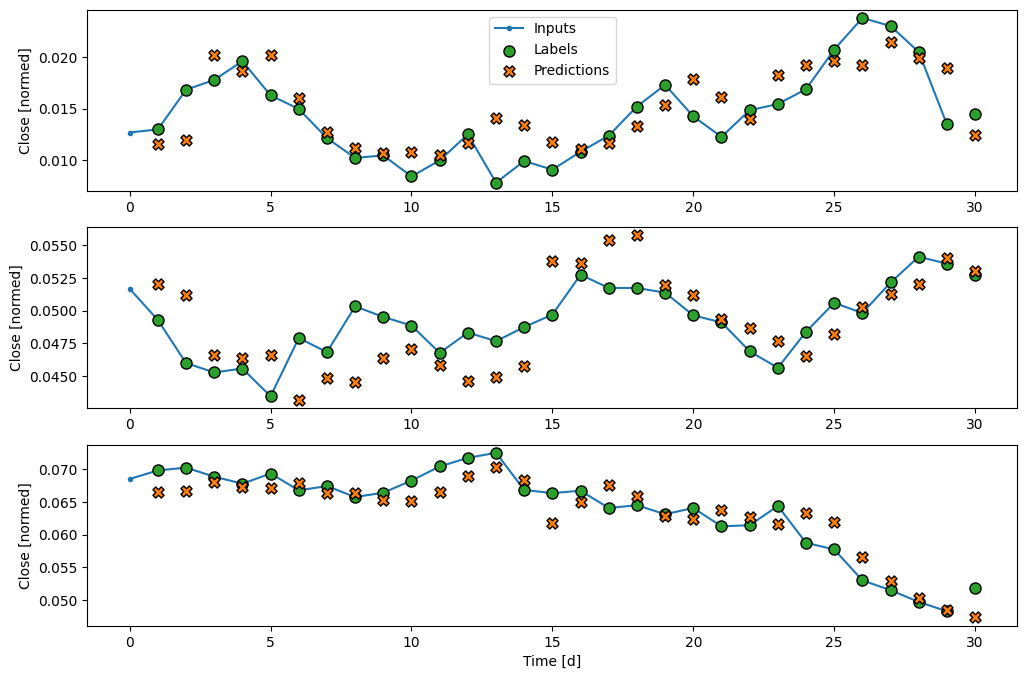

In [47]:
# dense model that consists of 3 dense layers with relu activation function, a deeper and more powerful model than the linear one
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


wide_window.plot('Close',model=dense)

38/38 [==============================] - 0s 3ms/step - loss: 0.0059 - mean_absolute_error: 0.0537


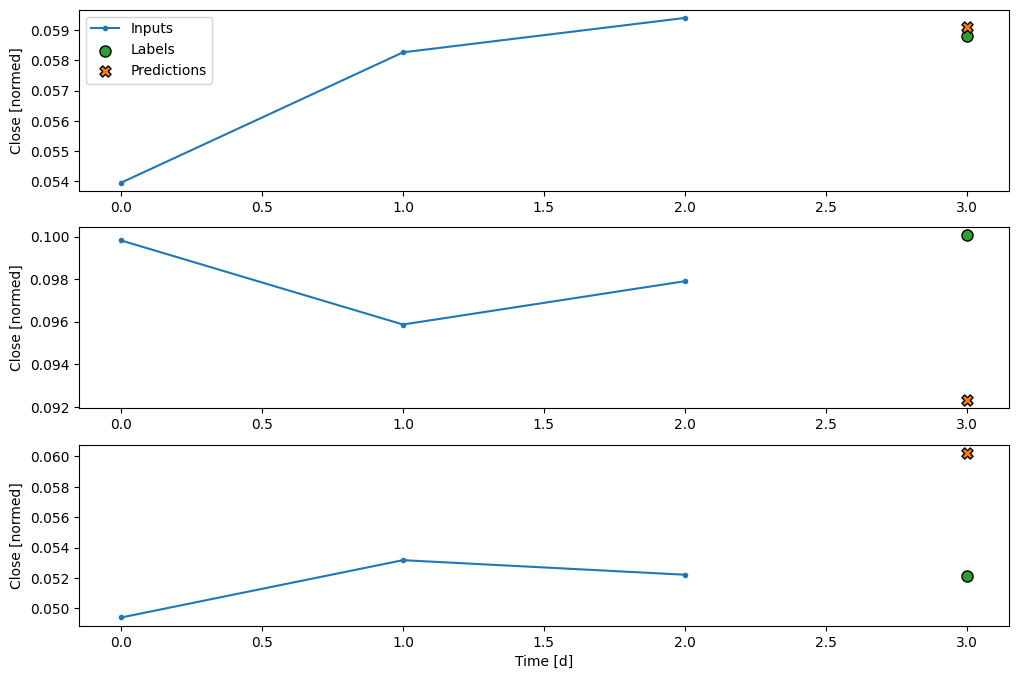

In [48]:
# THIS MODEL WORKS ON PRESET WINDOW INPUT WIDTH ONLY
# set to 3
CONV_WIDTH = 3
conv_window = WindowGenerator(
    train_df = train_df, val_df = val_df, test_df = test_df,
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Close'])

multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

print('Input shape:', wide_window.example[0].shape)

history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)
conv_window.plot('Close',model = multi_step_dense)


38/38 [==============================] - 0s 6ms/step - loss: 0.0917 - mean_absolute_error: 0.2401


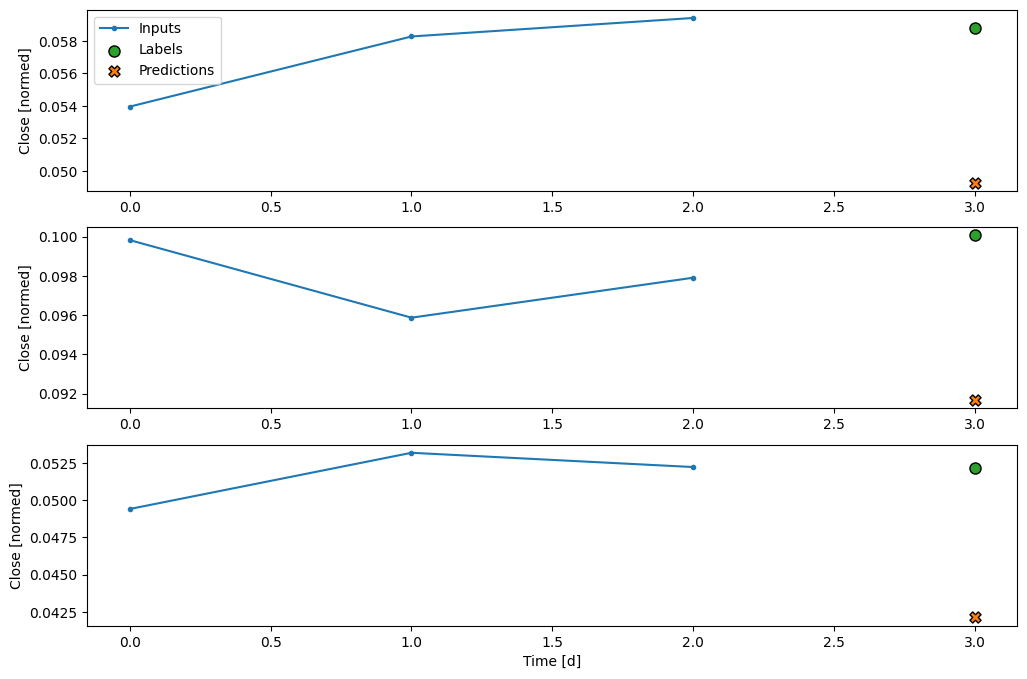

In [49]:
# SAME MODEL USING CONVOLUTION LAYER
# works with all window shapes (different input width)
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

conv_window.plot('Close',model = conv_model)


Wide conv window
Input shape: (32, 32, 7)
Labels shape: (32, 30, 1)
Output shape: (32, 30, 1)


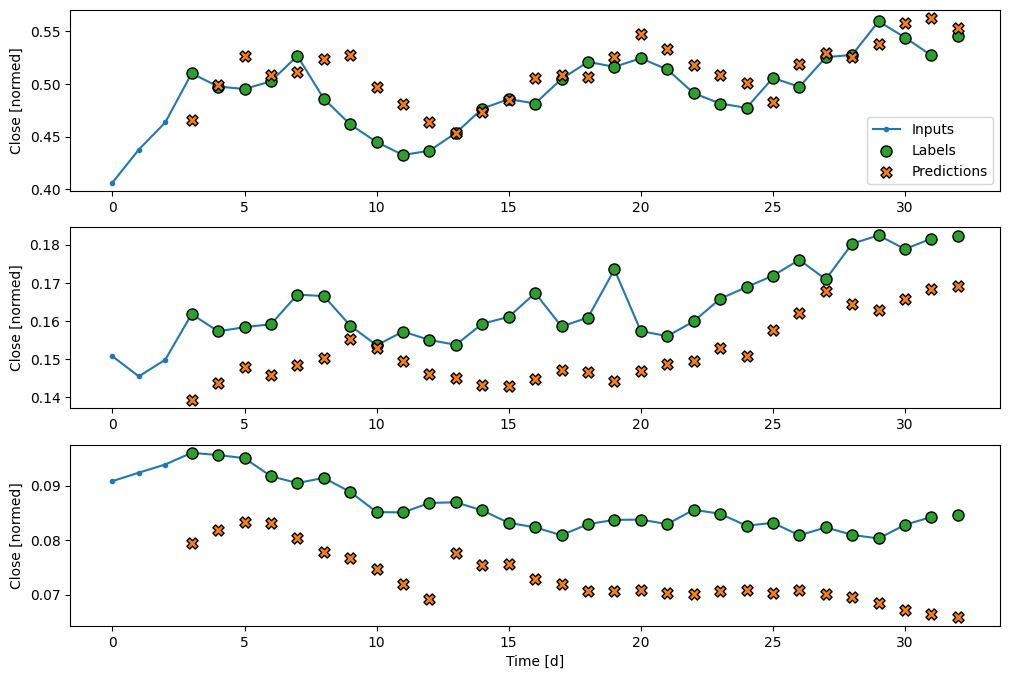

In [50]:
# CONVOLUTION MODEL ON WIDER WINDOW (30 days)
LABEL_WIDTH = 30
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    train_df = train_df, val_df = val_df, test_df = test_df,
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Close'])

print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

wide_conv_window.plot('Close',model=conv_model)


37/37 [==============================] - 0s 7ms/step - loss: 0.0796 - mean_absolute_error: 0.1870


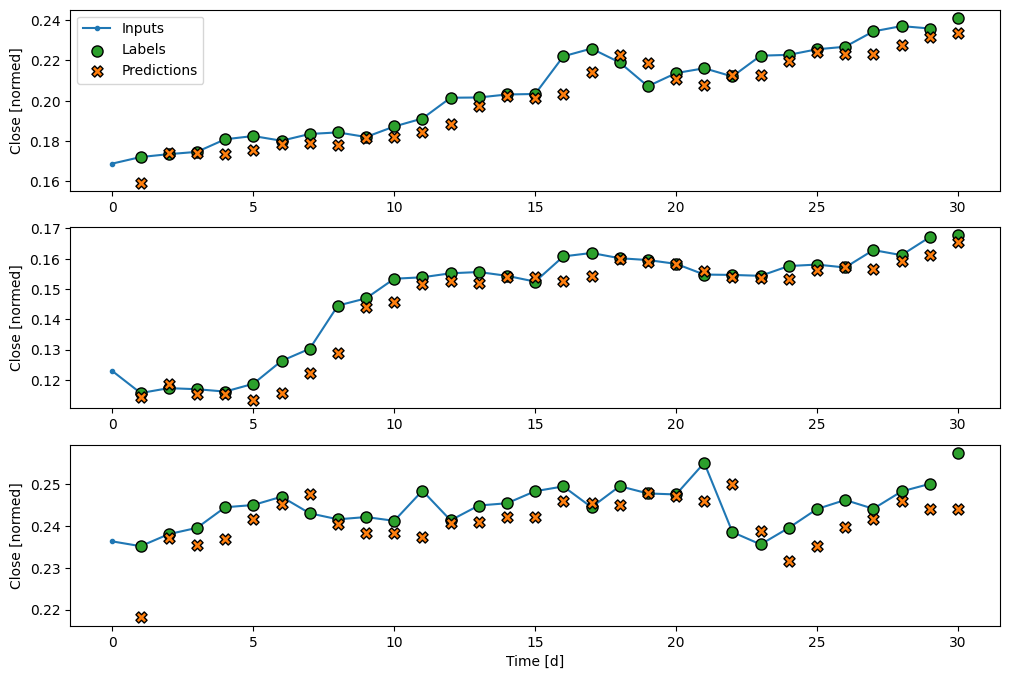

In [41]:
# BASIC LSTM MODEL
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

wide_window.plot('Close', model = lstm_model)


37/37 [==============================] - 0s 8ms/step - loss: 0.0397 - mean_absolute_error: 0.1026


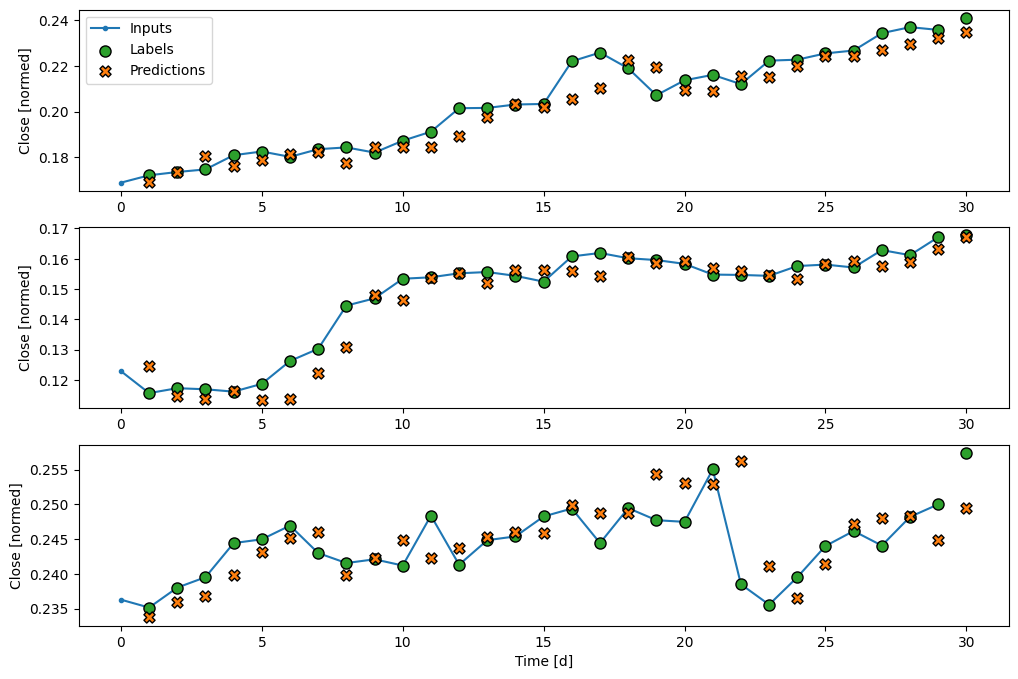

In [42]:
# Residual LSTM Model Using the Residual Wrapper
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

wide_window.plot('Close', model = residual_lstm)

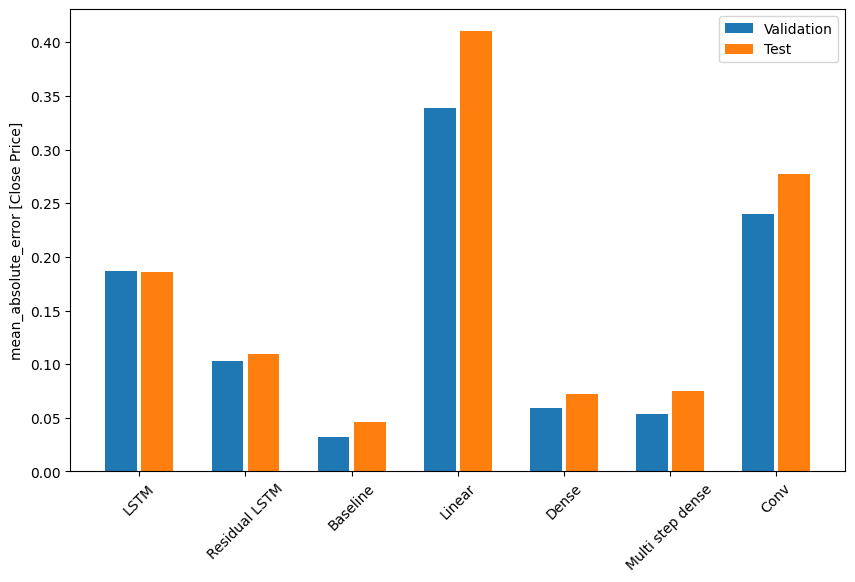

LSTM        : 0.1855
Residual LSTM: 0.1090
Baseline    : 0.0460
Linear      : 0.4102
Dense       : 0.0725
Multi step dense: 0.0745
Conv        : 0.2772


In [51]:
plt.figure(figsize=(10, 6))
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Close Price]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.legend()
plt.show()

for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

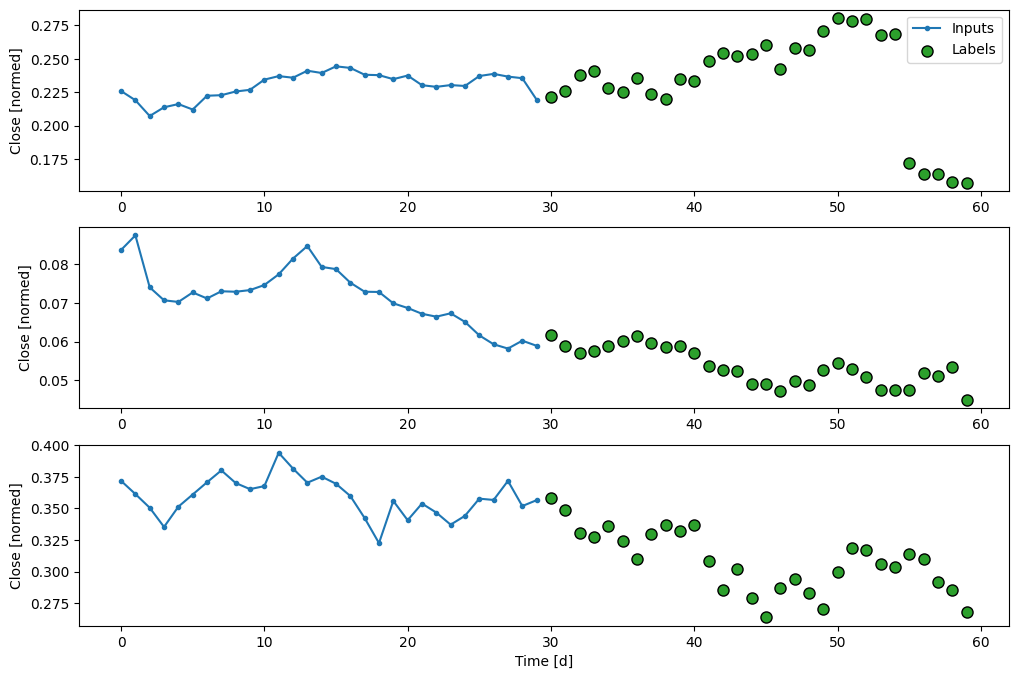

In [25]:
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=30,
                               train_df = train_df, val_df = val_df, test_df = test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['Close'])

multi_window.plot('Close')


36/36 [==============================] - 0s 3ms/step - loss: 0.6727 - mean_absolute_error: 0.4564


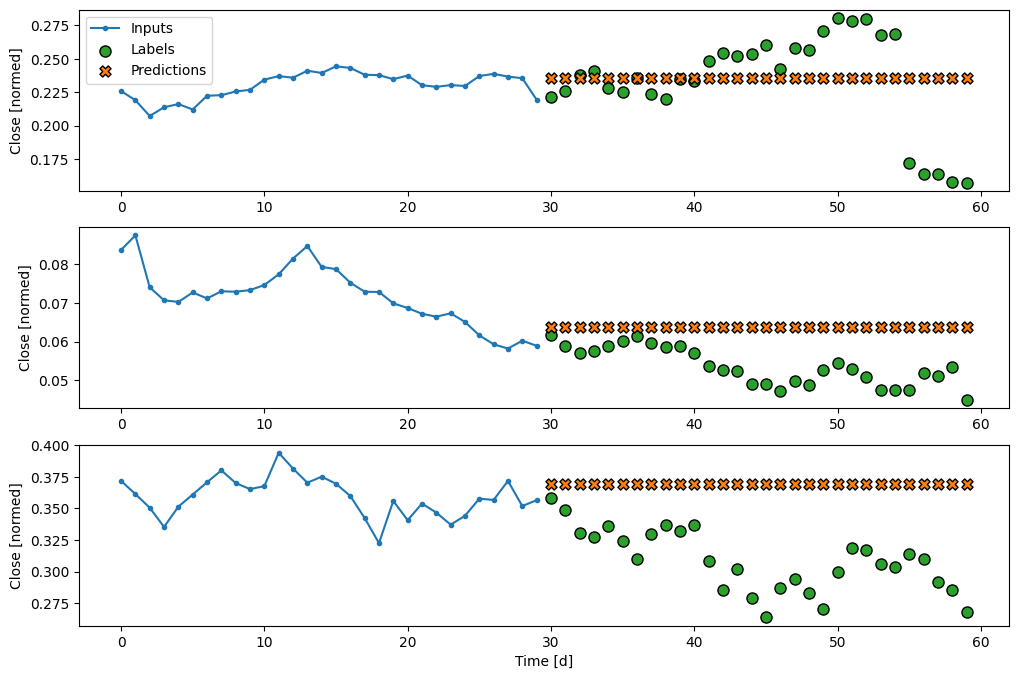

In [27]:
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot('Close',model = last_baseline)


36/36 [==============================] - 0s 6ms/step - loss: 0.6852 - mean_absolute_error: 0.4851


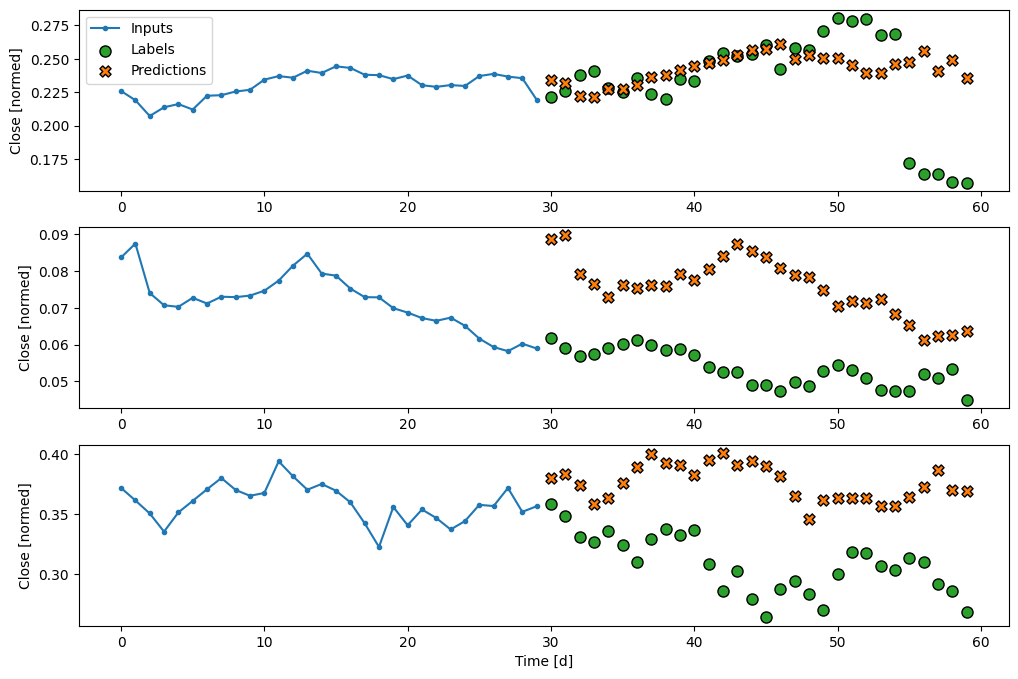

In [28]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot('Close',model = repeat_baseline)

36/36 [==============================] - 0s 4ms/step - loss: 0.0830 - mean_absolute_error: 0.2095


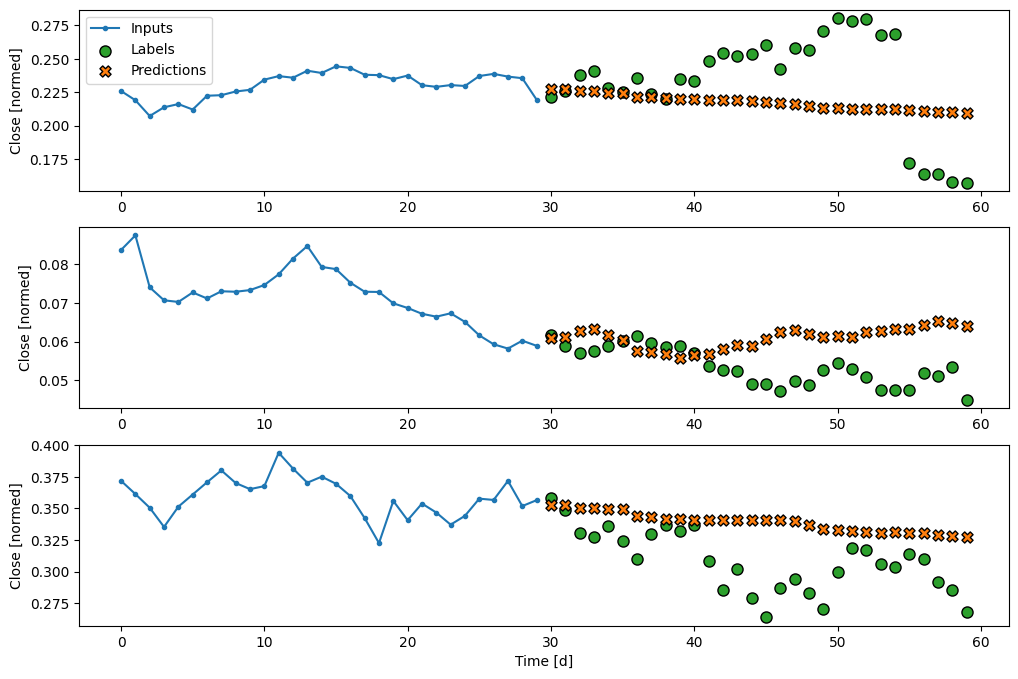

In [29]:
# MULTI STEP LINEAR MODEL 30 DAYS FORWARD
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot('Close',model = multi_linear_model)

36/36 [==============================] - 0s 4ms/step - loss: 0.2574 - mean_absolute_error: 0.3969


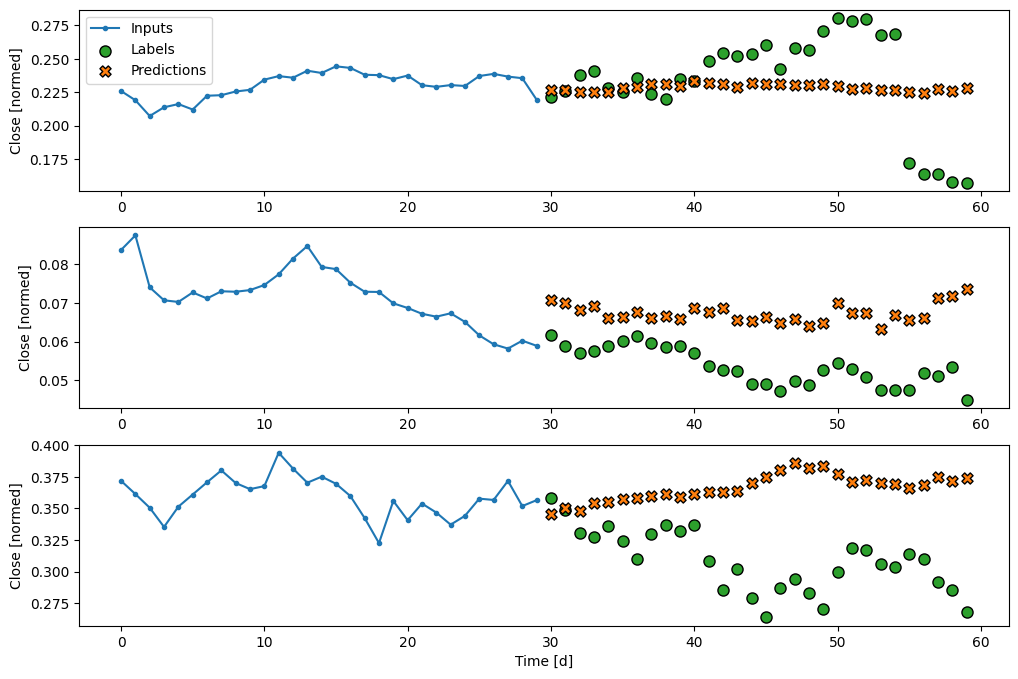

In [30]:
# MULTI STEP LINEAR (DENSE LAYER) MODEL 30 DAYS FORWARD
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot('Close',model = multi_dense_model)

36/36 [==============================] - 0s 3ms/step - loss: 0.1054 - mean_absolute_error: 0.2499


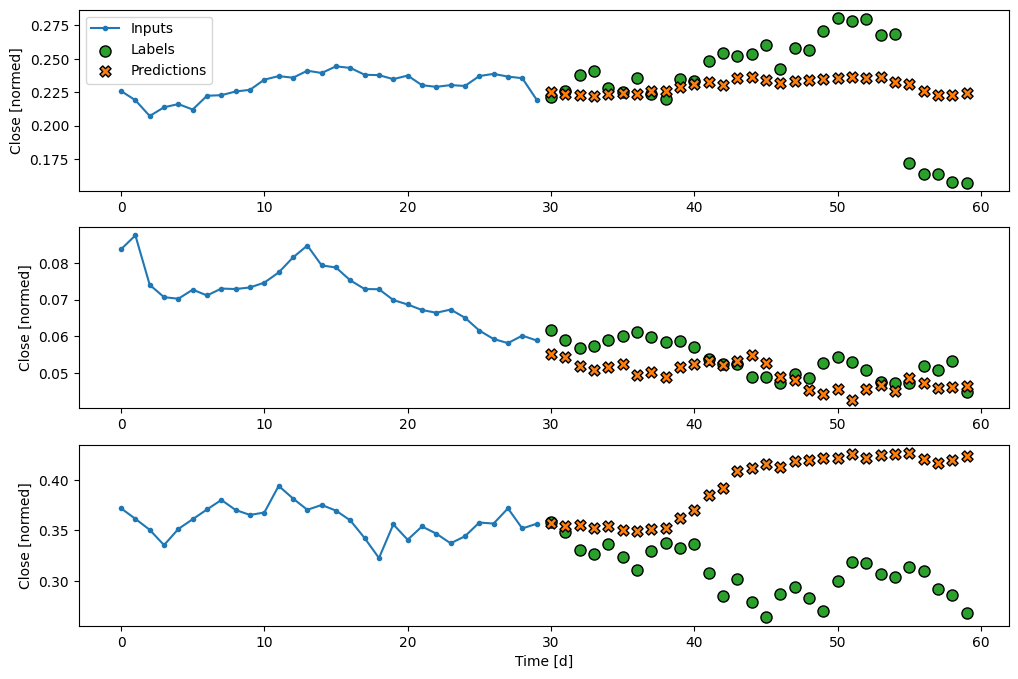

In [31]:
# CONVOLUTION MODEL FOR MULTI STEP WINDOW (30 DAYS AHEAD)
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot('Close',model = multi_conv_model)


In [54]:
# LSTM MODEL FOR MULTI STEP WINDOW (30 DAYS AHEAD)
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),

    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot('Close',model = multi_lstm_model)

Epoch 1/20
131/131 [==============================] - 7s 20ms/step - loss: 0.0065 - mean_absolute_error: 0.0475 - val_loss: 1.5920 - val_mean_absolute_error: 0.9741
Epoch 2/20
131/131 [==============================] - 2s 17ms/step - loss: 0.0024 - mean_absolute_error: 0.0270 - val_loss: 1.4719 - val_mean_absolute_error: 0.9190
Epoch 3/20
131/131 [==============================] - 3s 20ms/step - loss: 0.0022 - mean_absolute_error: 0.0248 - val_loss: 1.4178 - val_mean_absolute_error: 0.9061
Epoch 4/20
129/131 [============================>.] - ETA: 0s - loss: 0.0021 - mean_absolute_error: 0.0245

KeyboardInterrupt: ignored

In [33]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)
  def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

  def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
      # Use the last prediction as input.
      x = prediction
      # Execute one lstm step.
      x, state = self.lstm_cell(x, states=state,
                                training=training)
      # Convert the lstm output to a prediction.
      prediction = self.dense(x)
      # Add the prediction to the output.
      predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions



36/36 [==============================] - 1s 13ms/step - loss: 1.6612 - mean_absolute_error: 0.9914


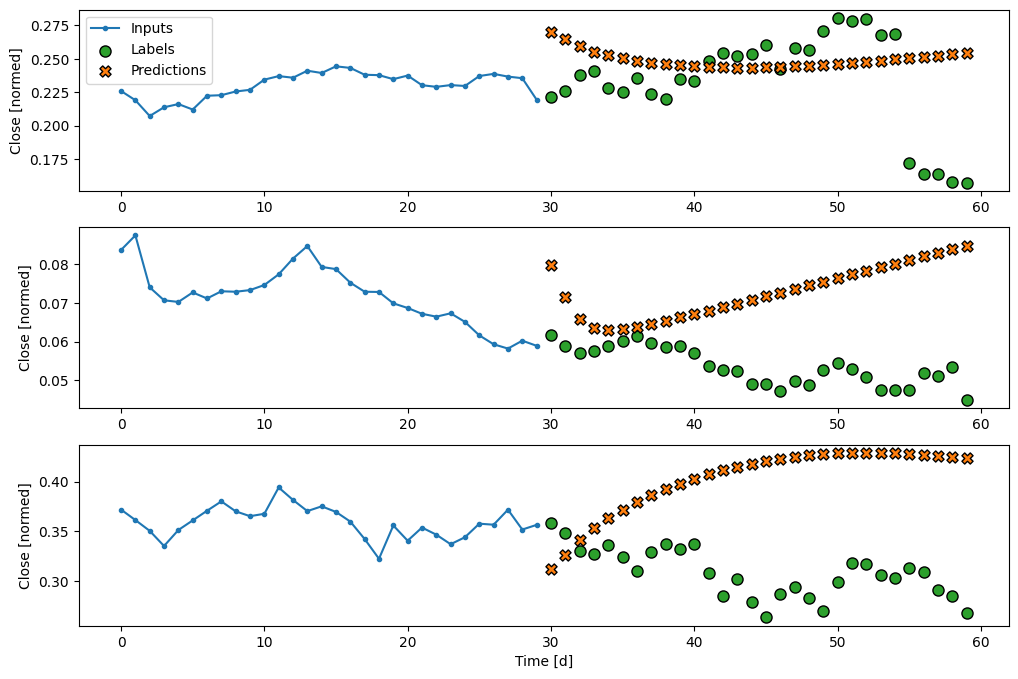

In [40]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot('Close',model = feedback_model)


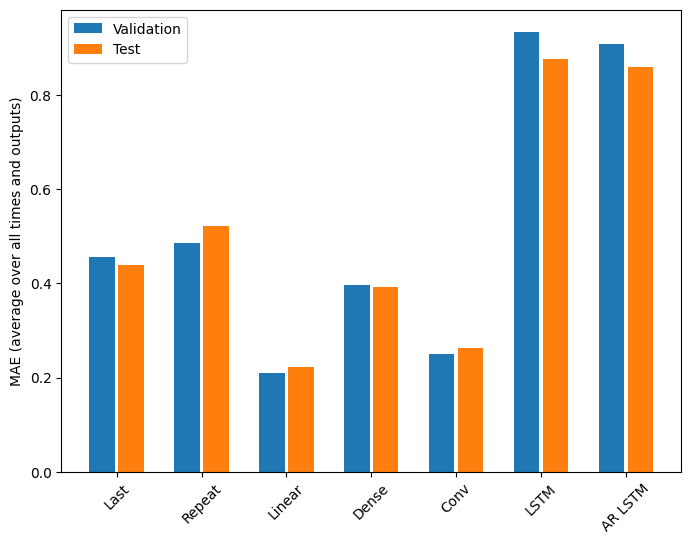

Last    : 0.4393
Repeat  : 0.5217
Linear  : 0.2226
Dense   : 0.3916
Conv    : 0.2620
LSTM    : 0.8778
AR LSTM : 0.8611


In [35]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
plt.legend()
plt.show()

for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')